#PACKAGE INSTALL

In [1]:
!pip install niapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 8.0 MB/s eta 0:00:00


In [2]:
!pip install --upgrade niapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install niapy --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import tensorflow as tf
import keras
import h5py
import random
import joblib

from keras.callbacks import EarlyStopping
from keras.layers import InputLayer, Dense, Dropout
from keras.models import Sequential

from niapy.algorithms.basic import GreyWolfOptimizer
from niapy.problems import Problem
from niapy.task import OptimizationType, Task
from sklearn.model_selection import train_test_split, cross_val_score


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

#DATA PREP

In [7]:
import pandas as pd
from google.colab import drive
import numpy as np

drive.mount('/content/drive')
path = '/content/drive/MyDrive/NR-ER'
savepath = '/content/drive/MyDrive/NR-ER/savedata'

Mounted at /content/drive


In [8]:
df_train = pd.read_csv("{}/train_resample_ros0_0.20.csv".format(path))
df_test = pd.read_csv("{}/test_NRER.csv".format(path))
df_train.head(2)
df_test.head(2)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP6,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,...,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP872,PubchemFP875,PubchemFP878,NR-ER
0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
X_train = df_train.drop('NR-ER', axis=1)
y_train = df_train['NR-ER']


X_test = df_test.drop('NR-ER', axis=1)
y_test = df_test['NR-ER']

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

#ANN FUNC

In [11]:
def get_hyperparameters(x):
    """Get hyperparameters for solution `x`."""
    hidden_layers = int(1 + (x[0] * 4)) #hidden layer minimal 1 maksimal 5
    node_num = []
    for i in range(5):
      node_num.append(int(32 + (x[i+1] * 96))) #128

    activation = ['tanh','relu','sigmoid']
    activations = activation[int(x[7] * 2 )]

    optimizers = ['Adam', 'SGD', 'RMSprop']
    optimizer = optimizers[int(x[8] * 2)]


    params = {
        'hidden_layers': hidden_layers,
        'node_num': node_num,
        'activation': activations,
        'optimizer': optimizer,

    }
    return params

In [12]:
import random
SEED = 0
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [13]:
def get_model(params):

    # Define the model architecture
    set_seeds()
    model = Sequential()

    model.add(InputLayer(input_shape=(732,)))

    for i in range(params['hidden_layers']) :
        model.add(Dense(params['node_num'][i],activation=params['activation']))

    model.add(Dense(1, activation='sigmoid'))

    # Map optimizer name to Keras optimizer object
    if params['optimizer'] == "SGD" : optimizer = SGD()
    elif params['optimizer'] == "RMSprop" : optimizer = RMSprop()
    elif params['optimizer'] == "Adam" : optimizer = Adam()

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [14]:
class ANNHyperparameterOptimization(Problem):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__(dimension=9, lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def _evaluate(self, x):
        params = get_hyperparameters(x)
        model = get_model(params)
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(self.X_train, self.y_train, epochs=200, batch_size=64, validation_data=(self.X_val, self.y_val), verbose=0, callbacks=[early_stop])

        return history.history['val_accuracy'][-1]

#BASELINE

In [ ]:
params = {'hidden_layers':1, 'node_num':[128], 'activation': 'relu', 'optimizer': 'Adam'}
model = get_model(params)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               93824     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 93,953
Trainable params: 93,953
Non-trainable params: 0
_________________________________________________________________


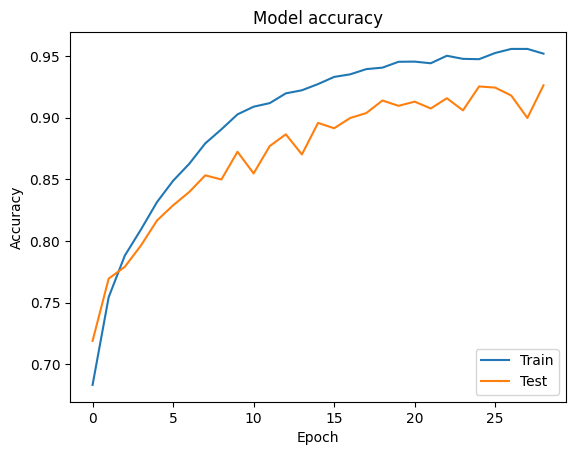

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

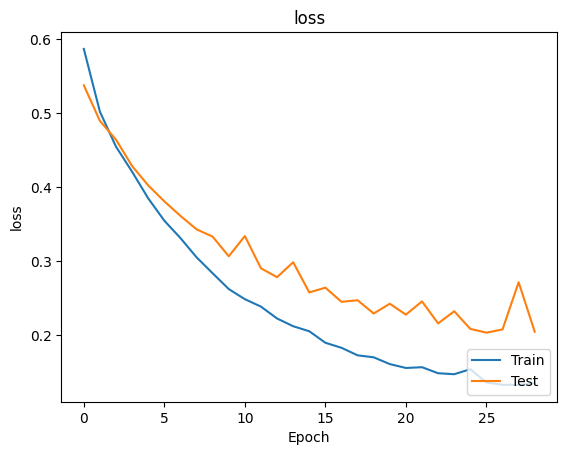

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [ ]:
y_predtrain_baseline = model.predict(X_train)
y_predtrain_baseline = (y_predtrain_baseline > 0.5)

cm_train = confusion_matrix(y_train, y_predtrain_baseline)

237/237 [==============================] - 0s 2ms/step


In [ ]:
cm_train

array([[3594,  182],
       [  97, 3695]])

In [ ]:
print("F1-score :", f1_score(y_train, y_predtrain_baseline))
print("Accuracy :", accuracy_score(y_train, y_predtrain_baseline))
print("Precision :", precision_score(y_train, y_predtrain_baseline))
print("Recall :", recall_score(y_train, y_predtrain_baseline))

F1-score : 0.9636197678967271
Accuracy : 0.9631342494714588
Precision : 0.9530564869744648
Recall : 0.9744198312236287


In [ ]:
y_predtest_baseline = model.predict(X_test)
y_predtest_baseline = (y_predtest_baseline > 0.5)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, y_predtest_baseline)

73/73 [==============================] - 0s 2ms/step


In [ ]:
cm_test

array([[1848,  180],
       [  91,  190]])

In [ ]:
print("F1-score :", f1_score(y_test, y_predtest_baseline))
print("Accuracy :", accuracy_score(y_test, y_predtest_baseline))
print("Precision :", precision_score(y_test, y_predtest_baseline))
print("Recall :", recall_score(y_test, y_predtest_baseline))

F1-score : 0.5837173579109064
Accuracy : 0.8826331745344305
Precision : 0.5135135135135135
Recall : 0.6761565836298933


#Searching Best Params for :

In [ ]:
population = [5, 10, 15, 20]

In [ ]:
convergence_data1 = {}
params1 = []
accuracy1 = []
save1 = {}

In [ ]:
convergence_data2 = {}
params2 = []
accuracy2 = []
save2 = {}

In [ ]:
convergence_data3 = {}
params3 = []
accuracy3 = []
save3 = {}

In [ ]:
convergence_data4 = {}
params4 = []
accuracy4 = []
save4 = {}

#Population 5

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 68)                49844     
                                                                 
 dense_3 (Dense)             (None, 120)               8280      
                                                                 
 dense_4 (Dense)             (None, 57)                6897      
                                                                 
 dense_5 (Dense)             (None, 62)                3596      
                                                                 
 dense_6 (Dense)             (None, 1)                 63        
                                                                 
Total params: 68,680
Trainable params: 68,680
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
____________________________

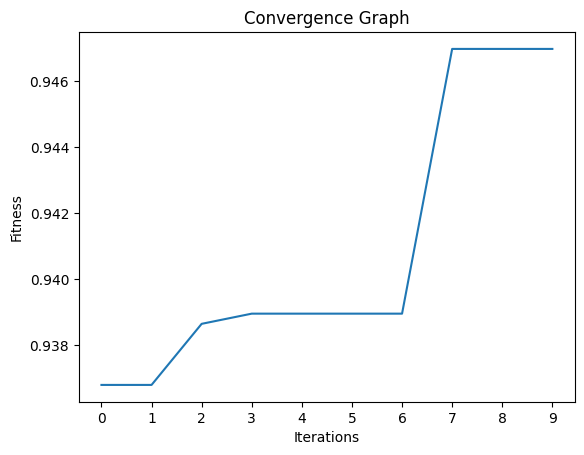

Best parameters with Population  5 {'hidden_layers': 2, 'node_num': [128, 55, 36, 41, 72], 'activation': 'tanh', 'optimizer': 'Adam'}
Best accuracy at Population  5 0.9469790458679199


In [ ]:
problem = ANNHyperparameterOptimization(X_train, y_train,X_val, y_val)
task = Task(problem, max_iters=10, optimization_type=OptimizationType.MAXIMIZATION)
algorithm = GreyWolfOptimizer(population_size=population[0],problem = problem, seed=1234)
best_params, best_accuracy = algorithm.run(task)
params1.append(best_params)
accuracy1.append(best_accuracy)
model = get_model(get_hyperparameters(best_params))
model.save("{}/model_pop5.h5".format(savepath))

x, y = task.convergence_data()
convergence_data1[(population[0])] = (x, y)
task.plot_convergence()

save1[(population[0])] = (accuracy1, params1)

joblib.dump(save1,"{}/model_pop5.pkl".format(savepath))
joblib.dump(convergence_data1,"{}/covgdata_pop5.pkl".format(savepath))
print('Best parameters with Population ', population[0], get_hyperparameters(best_params))
print('Best accuracy at Population ', population[0], best_accuracy)

#Population 10

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 68)                49844     
                                                                 
 dense_3 (Dense)             (None, 120)               8280      
                                                                 
 dense_4 (Dense)             (None, 57)                6897      
                                                                 
 dense_5 (Dense)             (None, 62)                3596      
                                                                 
 dense_6 (Dense)             (None, 1)                 63        
                                                                 
Total params: 68,680
Trainable params: 68,680
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
____________________________

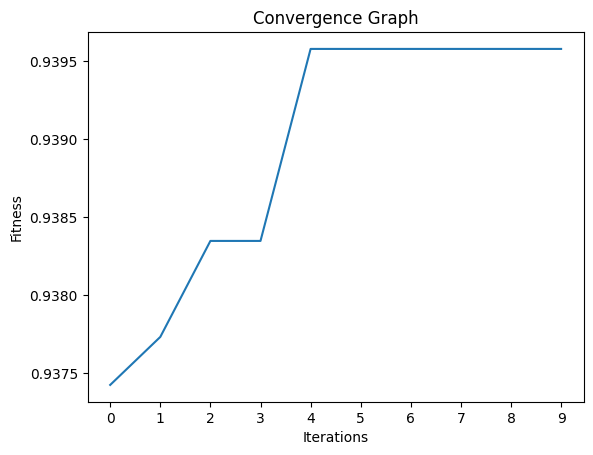

Best parameters with Population  10 {'hidden_layers': 2, 'node_num': [128, 47, 128, 103, 80], 'activation': 'tanh', 'optimizer': 'Adam'}
Best accuracy at Population  10 0.9395807385444641


In [ ]:
problem = ANNHyperparameterOptimization(X_train, y_train,X_val, y_val)
task = Task(problem, max_iters=10, optimization_type=OptimizationType.MAXIMIZATION)
algorithm = GreyWolfOptimizer(population_size=population[1],problem = problem, seed=1234)
best_params, best_accuracy = algorithm.run(task)
params2.append(best_params)
accuracy2.append(best_accuracy)
model = get_model(get_hyperparameters(best_params))
model.save("{}/model_pop10.h5".format(savepath))

x, y = task.convergence_data()
convergence_data2[(population[1])] = (x, y)
task.plot_convergence()

save2[(population[1])] = (accuracy2, params2)

joblib.dump(save2,"{}/model_pop10.pkl".format(savepath))
joblib.dump(convergence_data2,"{}/covgdata_pop10.pkl".format(savepath))
print('Best parameters with Population ', population[1], get_hyperparameters(best_params))
print('Best accuracy at Population ', population[1], best_accuracy)

#Population 15

Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_266 (Dense)           (None, 68)                49844     
                                                                 
 dense_267 (Dense)           (None, 120)               8280      
                                                                 
 dense_268 (Dense)           (None, 57)                6897      
                                                                 
 dense_269 (Dense)           (None, 62)                3596      
                                                                 
 dense_270 (Dense)           (None, 1)                 63        
                                                                 
Total params: 68,680
Trainable params: 68,680
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_113"
________________________

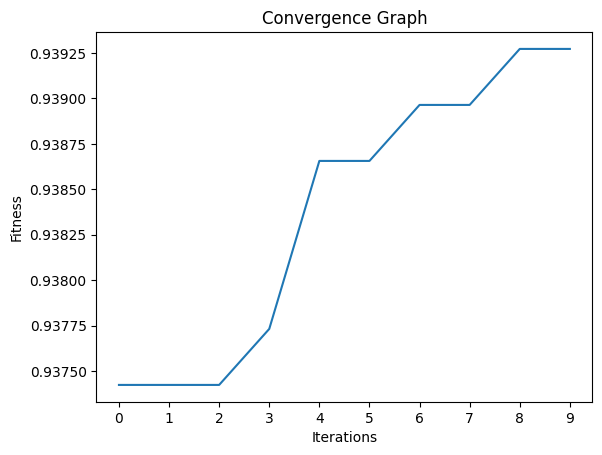

Best parameters with Population  15 {'hidden_layers': 1, 'node_num': [116, 128, 54, 96, 67], 'activation': 'tanh', 'optimizer': 'Adam'}
Best accuracy at Population  15 0.9392725229263306


In [ ]:
problem = ANNHyperparameterOptimization(X_train, y_train,X_val, y_val)
task = Task(problem, max_iters=10, optimization_type=OptimizationType.MAXIMIZATION)
algorithm = GreyWolfOptimizer(population_size=population[2],problem = problem, seed=1234)
best_params, best_accuracy = algorithm.run(task)
params3.append(best_params)
accuracy3.append(best_accuracy)
model = get_model(get_hyperparameters(best_params))
model.save("{}/model_pop15.h5".format(savepath))

x, y = task.convergence_data()
convergence_data3[(population[2])] = (x, y)
task.plot_convergence()

save3[(population[2])] = (accuracy3, params3)

joblib.dump(save3,"{}/model_pop15.pkl".format(savepath))
joblib.dump(convergence_data3,"{}/covgdata_pop15.pkl".format(savepath))
print('Best parameters with Population ', population[2], get_hyperparameters(best_params))
print('Best accuracy at Population ', population[2], best_accuracy)

#Population 20

Model: "sequential_278"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_701 (Dense)           (None, 68)                49844     
                                                                 
 dense_702 (Dense)           (None, 120)               8280      
                                                                 
 dense_703 (Dense)           (None, 57)                6897      
                                                                 
 dense_704 (Dense)           (None, 62)                3596      
                                                                 
 dense_705 (Dense)           (None, 1)                 63        
                                                                 
Total params: 68,680
Trainable params: 68,680
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_279"
________________________

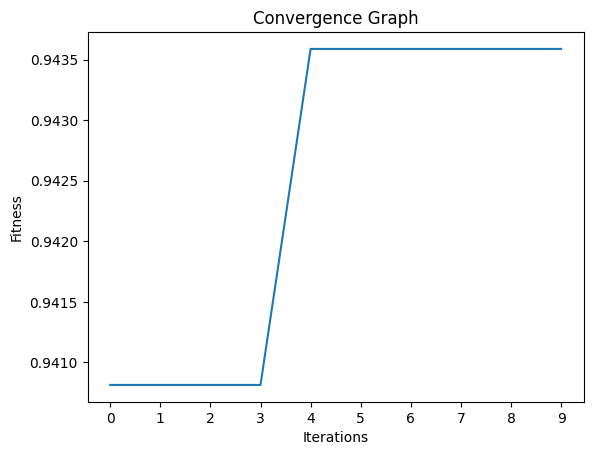

Best parameters with Population  20 {'hidden_layers': 2, 'node_num': [115, 32, 44, 89, 126], 'activation': 'tanh', 'optimizer': 'Adam'}
Best accuracy at Population  20 0.943588137626648


In [ ]:
problem = ANNHyperparameterOptimization(X_train, y_train,X_val, y_val)
task = Task(problem, max_iters=10, optimization_type=OptimizationType.MAXIMIZATION)
algorithm = GreyWolfOptimizer(population_size=population[3],problem = problem, seed=1234)
best_params, best_accuracy = algorithm.run(task)
params4.append(best_params)
accuracy4.append(best_accuracy)
model = get_model(get_hyperparameters(best_params))
model.save("{}/model_pop20.h5".format(savepath))

x, y = task.convergence_data()
convergence_data4[(population[3])] = (x, y)
task.plot_convergence()

save4[(population[3])] = (accuracy4, params4)

joblib.dump(save4,"{}/model_pop20.pkl".format(savepath))
joblib.dump(convergence_data4,"{}/covgdata_pop20.pkl".format(savepath))
print('Best parameters with Population ', population[3], get_hyperparameters(best_params))
print('Best accuracy at Population ', population[3], best_accuracy)

#BASELINE PARAMS

In [15]:
baseline_params = {'hidden_layers':1, 'node_num':[128], 'activation': 'relu', 'optimizer': 'Adam'}
early_stop = EarlyStopping(monitor='val_loss', patience=2)

baseline = get_model(baseline_params)
history = baseline.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])
len(history.history['val_loss'])
baseline.save("{}/baseline.h5".format(savepath))

loss, accuracy = baseline.evaluate(X_test, y_test)
print(f'Accuracy for baseline: {accuracy}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               93824     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 93,953
Trainable params: 93,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
237/237 [==============================] - 2s 5ms/step - loss: 0.5525 - accuracy: 0.7142 - val_loss: 0.5175 - val_accuracy: 0.7330
Epoch 2/200
237/237 [==============================] - 1s 5ms/step - loss: 0.4568 - accuracy: 0.7780 - val_loss: 0.4589 - val_accuracy: 0.7814
Epoch 3/200
237/237 [==============================] - 1s 5ms/step - loss: 0.4058 - accuracy: 0.8173 - val_loss: 0.4227 - val_accuracy: 0.7993
Epoch 4/200
237/237

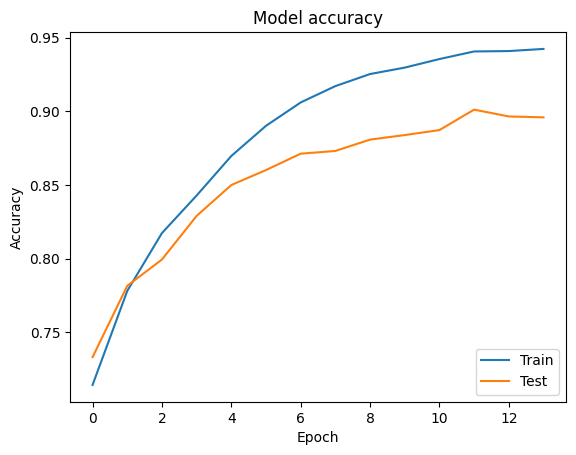

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

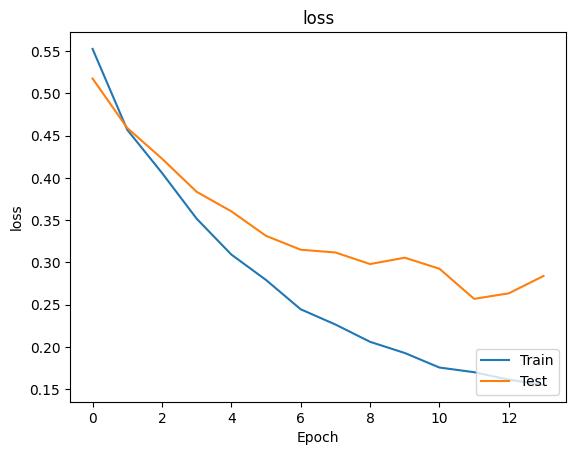

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [18]:
y_predtrain_baseline = baseline.predict(X_train)
y_predtrain_baseline = (y_predtrain_baseline > 0.5)

cm_train = confusion_matrix(y_train, y_predtrain_baseline)

237/237 [==============================] - 1s 2ms/step


In [19]:
cm_train

array([[3527,  278],
       [  94, 3669]])

In [20]:
print("F1-score :", f1_score(y_train, y_predtrain_baseline))
print("Accuracy :", accuracy_score(y_train, y_predtrain_baseline))
print("Precision :", precision_score(y_train, y_predtrain_baseline))
print("Recall :", recall_score(y_train, y_predtrain_baseline))

F1-score : 0.951750972762646
Accuracy : 0.9508456659619451
Precision : 0.929566759564226
Recall : 0.9750199309061919


In [21]:
y_predtest_baseline = baseline.predict(X_test)
y_predtest_baseline = (y_predtest_baseline > 0.5)

cm_test = confusion_matrix(y_test, y_predtest_baseline)

73/73 [==============================] - 0s 2ms/step


In [22]:
cm_test

array([[1784,  244],
       [  82,  199]])

In [23]:
print("F1-score :", f1_score(y_test, y_predtest_baseline))
print("Accuracy :", accuracy_score(y_test, y_predtest_baseline))
print("Precision :", precision_score(y_test, y_predtest_baseline))
print("Recall :", recall_score(y_test, y_predtest_baseline))

F1-score : 0.5497237569060773
Accuracy : 0.8588133391078389
Precision : 0.4492099322799097
Recall : 0.708185053380783


#BEST PARAMS LOAD

In [24]:
pop5 = joblib.load("{}/model_pop5.pkl".format(savepath))
pop10 = joblib.load("{}/model_pop10.pkl".format(savepath))
pop15 = joblib.load("{}/model_pop15.pkl".format(savepath))
pop20 = joblib.load("{}/model_pop20.pkl".format(savepath))

params = {}
params = {**pop5, **pop10, **pop15, **pop20}

#BEST PARAMS POP5

In [73]:
best_params = params[5][1][0]

model5 = get_model(get_hyperparameters(best_params))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 128)               93824     
                                                                 
 dense_14 (Dense)            (None, 55)                7095      
                                                                 
 dense_15 (Dense)            (None, 1)                 56        
                                                                 
Total params: 100,975
Trainable params: 100,975
Non-trainable params: 0
_________________________________________________________________


In [74]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history5 = model5.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

Epoch 1/200
119/119 [==============================] - 1s 7ms/step - loss: 0.5606 - accuracy: 0.7051 - val_loss: 0.5322 - val_accuracy: 0.7207
Epoch 2/200
119/119 [==============================] - 1s 6ms/step - loss: 0.4831 - accuracy: 0.7637 - val_loss: 0.4944 - val_accuracy: 0.7602
Epoch 3/200
119/119 [==============================] - 1s 5ms/step - loss: 0.4476 - accuracy: 0.7863 - val_loss: 0.4785 - val_accuracy: 0.7605
Epoch 4/200
119/119 [==============================] - 1s 6ms/step - loss: 0.4074 - accuracy: 0.8133 - val_loss: 0.4378 - val_accuracy: 0.7987
Epoch 5/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3718 - accuracy: 0.8317 - val_loss: 0.4168 - val_accuracy: 0.8036
Epoch 6/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3402 - accuracy: 0.8527 - val_loss: 0.3909 - val_accuracy: 0.8314
Epoch 7/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3160 - accuracy: 0.8589 - val_loss: 0.3911 - val_accuracy: 0.8231

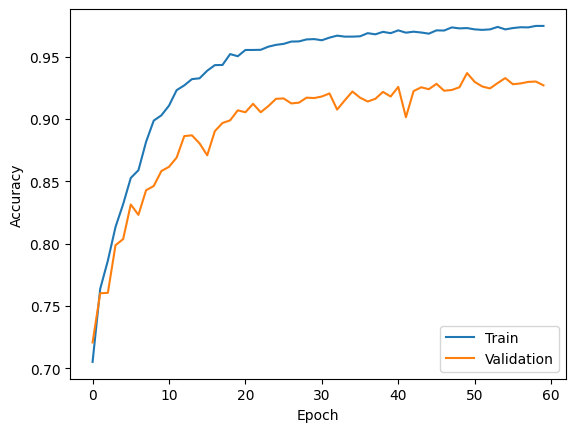

In [75]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

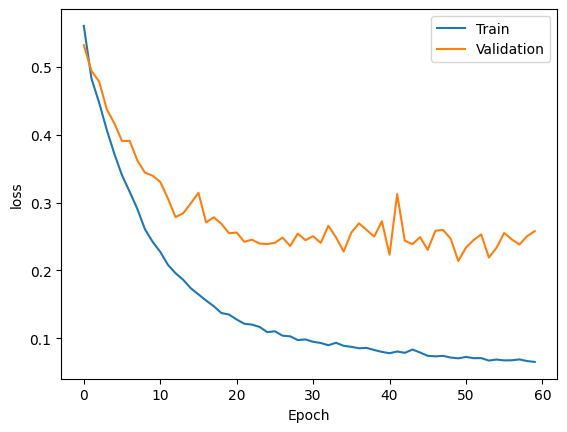

In [76]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [77]:
y_predtrain_pop5 = model5.predict(X_train)
y_predtrain_pop5 = (y_predtrain_pop5 > 0.5)

from sklearn.metrics import confusion_matrix
cm_train_pop5 = confusion_matrix(y_train, y_predtrain_pop5)

237/237 [==============================] - 0s 2ms/step


In [78]:
cm_train_pop5

array([[3657,  148],
       [  26, 3737]])

In [79]:
print("F1-score :", f1_score(y_train, y_predtrain_pop5))
print("Accuracy :", accuracy_score(y_train, y_predtrain_pop5))
print("Precision :", precision_score(y_train, y_predtrain_pop5))
print("Recall :", recall_score(y_train, y_predtrain_pop5))

F1-score : 0.9772489539748954
Accuracy : 0.9770084566596194
Precision : 0.9619047619047619
Recall : 0.9930906191868191


In [80]:
y_predtest_pop5 = model5.predict(X_test)
y_predtest_pop5 = (y_predtest_pop5 > 0.5)

from sklearn.metrics import confusion_matrix
cm_test_pop5 = confusion_matrix(y_test, y_predtest_pop5)

73/73 [==============================] - 0s 2ms/step


In [81]:
cm_test_pop5

array([[1841,  187],
       [  92,  189]])

In [82]:
print("F1-score :", f1_score(y_test, y_predtest_pop5))
print("Accuracy :", accuracy_score(y_test, y_predtest_pop5))
print("Precision :", precision_score(y_test, y_predtest_pop5))
print("Recall :", recall_score(y_test, y_predtest_pop5))

F1-score : 0.5753424657534246
Accuracy : 0.8791684711996536
Precision : 0.5026595744680851
Recall : 0.6725978647686833


#BEST PARAMS POP10

In [83]:
best_params = params[10][1][0]

model10 = get_model(get_hyperparameters(best_params))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               93824     
                                                                 
 dense_17 (Dense)            (None, 47)                6063      
                                                                 
 dense_18 (Dense)            (None, 1)                 48        
                                                                 
Total params: 99,935
Trainable params: 99,935
Non-trainable params: 0
_________________________________________________________________


In [84]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history10 = model10.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

Epoch 1/200
119/119 [==============================] - 1s 6ms/step - loss: 0.5612 - accuracy: 0.7031 - val_loss: 0.5314 - val_accuracy: 0.7207
Epoch 2/200
119/119 [==============================] - 1s 5ms/step - loss: 0.4841 - accuracy: 0.7587 - val_loss: 0.4930 - val_accuracy: 0.7488
Epoch 3/200
119/119 [==============================] - 1s 5ms/step - loss: 0.4447 - accuracy: 0.7900 - val_loss: 0.4732 - val_accuracy: 0.7688
Epoch 4/200
119/119 [==============================] - 1s 6ms/step - loss: 0.4050 - accuracy: 0.8175 - val_loss: 0.4342 - val_accuracy: 0.7925
Epoch 5/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3672 - accuracy: 0.8363 - val_loss: 0.4091 - val_accuracy: 0.8039
Epoch 6/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3366 - accuracy: 0.8557 - val_loss: 0.3871 - val_accuracy: 0.8308
Epoch 7/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3165 - accuracy: 0.8611 - val_loss: 0.3773 - val_accuracy: 0.8317

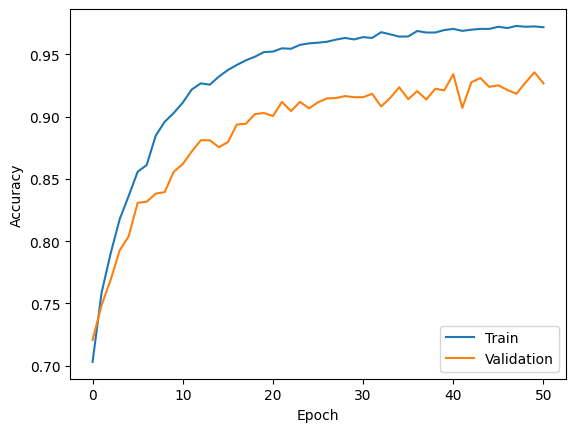

In [85]:
plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

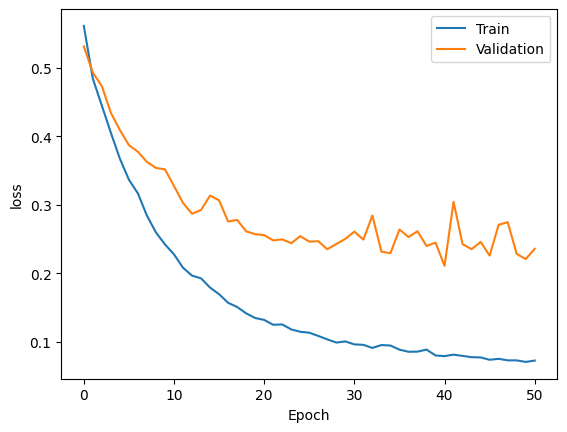

In [86]:
plt.plot(history10.history['loss'])
plt.plot(history10.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [87]:
y_predtrain_pop10 = model10.predict(X_train)
y_predtrain_pop10 = (y_predtrain_pop10 > 0.5)

from sklearn.metrics import confusion_matrix
cm_train_pop10 = confusion_matrix(y_train, y_predtrain_pop10)

237/237 [==============================] - 1s 2ms/step


In [88]:
cm_train_pop10

array([[3675,  130],
       [  47, 3716]])

In [89]:
print("F1-score :", f1_score(y_train, y_predtrain_pop10))
print("Accuracy :", accuracy_score(y_train, y_predtrain_pop10))
print("Precision :", precision_score(y_train, y_predtrain_pop10))
print("Recall :", recall_score(y_train, y_predtrain_pop10))

F1-score : 0.9767380733342096
Accuracy : 0.9766120507399577
Precision : 0.9661986479459178
Recall : 0.9875099654530959


In [90]:
y_predtest_pop10 = model10.predict(X_test)
y_predtest_pop10 = (y_predtest_pop10 > 0.5)

from sklearn.metrics import confusion_matrix
cm_test_pop10 = confusion_matrix(y_test, y_predtest_pop10)

73/73 [==============================] - 0s 2ms/step


In [91]:
cm_test_pop10

array([[1863,  165],
       [  94,  187]])

In [92]:
print("F1-score :", f1_score(y_test, y_predtest_pop10))
print("Accuracy :", accuracy_score(y_test, y_predtest_pop10))
print("Precision :", precision_score(y_test, y_predtest_pop10))
print("Recall :", recall_score(y_test, y_predtest_pop10))

F1-score : 0.5908372827804107
Accuracy : 0.887830229536596
Precision : 0.53125
Recall : 0.6654804270462633


#BEST PARAMS POP15

In [93]:
best_params = params[15][1][0]

model15 = get_model(get_hyperparameters(best_params))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 116)               85028     
                                                                 
 dense_20 (Dense)            (None, 1)                 117       
                                                                 
Total params: 85,145
Trainable params: 85,145
Non-trainable params: 0
_________________________________________________________________


In [94]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history15 = model15.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

Epoch 1/200
119/119 [==============================] - 2s 6ms/step - loss: 0.5695 - accuracy: 0.6989 - val_loss: 0.5482 - val_accuracy: 0.7127
Epoch 2/200
119/119 [==============================] - 1s 5ms/step - loss: 0.5039 - accuracy: 0.7456 - val_loss: 0.5188 - val_accuracy: 0.7401
Epoch 3/200
119/119 [==============================] - 1s 5ms/step - loss: 0.4820 - accuracy: 0.7632 - val_loss: 0.5069 - val_accuracy: 0.7454
Epoch 4/200
119/119 [==============================] - 1s 5ms/step - loss: 0.4586 - accuracy: 0.7784 - val_loss: 0.4964 - val_accuracy: 0.7568
Epoch 5/200
119/119 [==============================] - 1s 5ms/step - loss: 0.4406 - accuracy: 0.7945 - val_loss: 0.4794 - val_accuracy: 0.7642
Epoch 6/200
119/119 [==============================] - 1s 5ms/step - loss: 0.4208 - accuracy: 0.8056 - val_loss: 0.4606 - val_accuracy: 0.7827
Epoch 7/200
119/119 [==============================] - 1s 5ms/step - loss: 0.4138 - accuracy: 0.8088 - val_loss: 0.4593 - val_accuracy: 0.7771

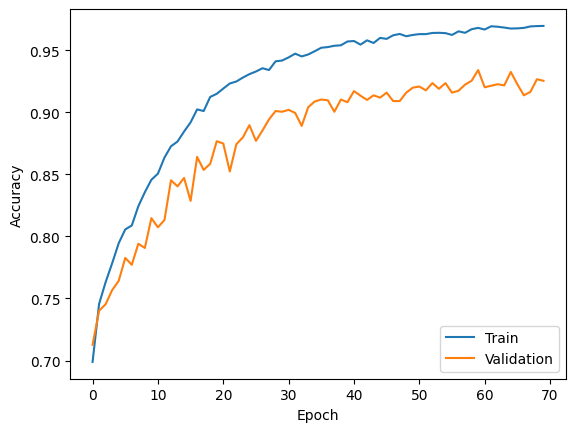

In [95]:
plt.plot(history15.history['accuracy'])
plt.plot(history15.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

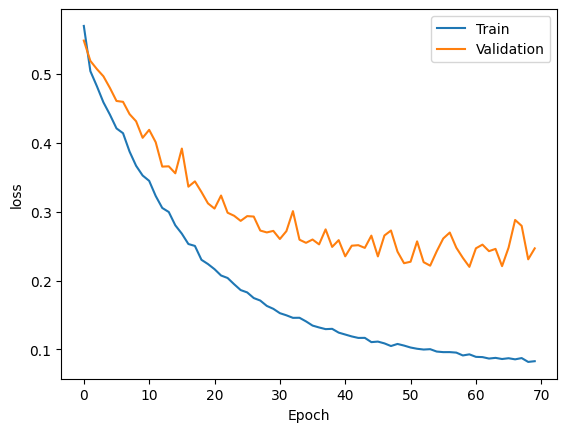

In [96]:
plt.plot(history15.history['loss'])
plt.plot(history15.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [97]:
y_predtrain_pop15 = model15.predict(X_train)
y_predtrain_pop15 = (y_predtrain_pop15 > 0.5)

from sklearn.metrics import confusion_matrix
cm_train_pop15 = confusion_matrix(y_train, y_predtrain_pop15)

237/237 [==============================] - 0s 2ms/step


In [98]:
cm_train_pop15

array([[3644,  161],
       [  36, 3727]])

In [99]:
print("F1-score :", f1_score(y_train, y_predtrain_pop15))
print("Accuracy :", accuracy_score(y_train, y_predtrain_pop15))
print("Precision :", precision_score(y_train, y_predtrain_pop15))
print("Recall :", recall_score(y_train, y_predtrain_pop15))

F1-score : 0.9742517317997647
Accuracy : 0.9739693446088795
Precision : 0.9585905349794238
Recall : 0.9904331650279032


In [100]:
y_predtest_pop15 = model15.predict(X_test)
y_predtest_pop15 = (y_predtest_pop15 > 0.5)

from sklearn.metrics import confusion_matrix
cm_test_pop15 = confusion_matrix(y_test, y_predtest_pop15)

73/73 [==============================] - 0s 2ms/step


In [101]:
cm_test_pop15

array([[1831,  197],
       [  87,  194]])

In [102]:
print("F1-score :", f1_score(y_test, y_predtest_pop15))
print("Accuracy :", accuracy_score(y_test, y_predtest_pop15))
print("Precision :", precision_score(y_test, y_predtest_pop15))
print("Recall :", recall_score(y_test, y_predtest_pop15))

F1-score : 0.5773809523809523
Accuracy : 0.8770030316154179
Precision : 0.4961636828644501
Recall : 0.6903914590747331


#BEST PARAMS POP20

In [103]:
best_params = params[20][1][0]

model20 = get_model(get_hyperparameters(best_params))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 115)               84295     
                                                                 
 dense_22 (Dense)            (None, 32)                3712      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 88,040
Trainable params: 88,040
Non-trainable params: 0
_________________________________________________________________


In [104]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history20 = model20.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

Epoch 1/200
119/119 [==============================] - 1s 6ms/step - loss: 0.5567 - accuracy: 0.7065 - val_loss: 0.5306 - val_accuracy: 0.7229
Epoch 2/200
119/119 [==============================] - 1s 6ms/step - loss: 0.4783 - accuracy: 0.7666 - val_loss: 0.4928 - val_accuracy: 0.7568
Epoch 3/200
119/119 [==============================] - 1s 6ms/step - loss: 0.4398 - accuracy: 0.7944 - val_loss: 0.4689 - val_accuracy: 0.7657
Epoch 4/200
119/119 [==============================] - 1s 6ms/step - loss: 0.4037 - accuracy: 0.8169 - val_loss: 0.4426 - val_accuracy: 0.7907
Epoch 5/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3690 - accuracy: 0.8372 - val_loss: 0.4235 - val_accuracy: 0.8021
Epoch 6/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3410 - accuracy: 0.8584 - val_loss: 0.4015 - val_accuracy: 0.8203
Epoch 7/200
119/119 [==============================] - 1s 5ms/step - loss: 0.3198 - accuracy: 0.8647 - val_loss: 0.3794 - val_accuracy: 0.8335

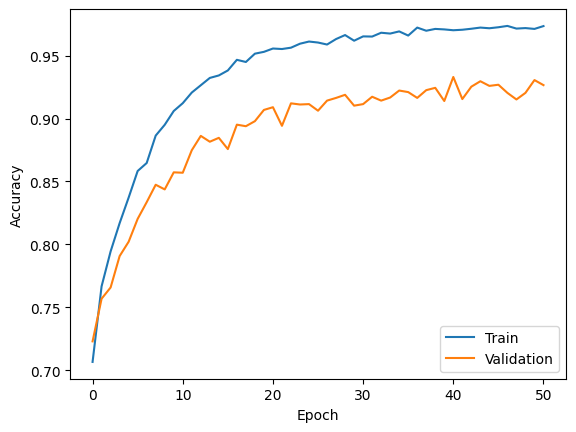

In [105]:
plt.plot(history20.history['accuracy'])
plt.plot(history20.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

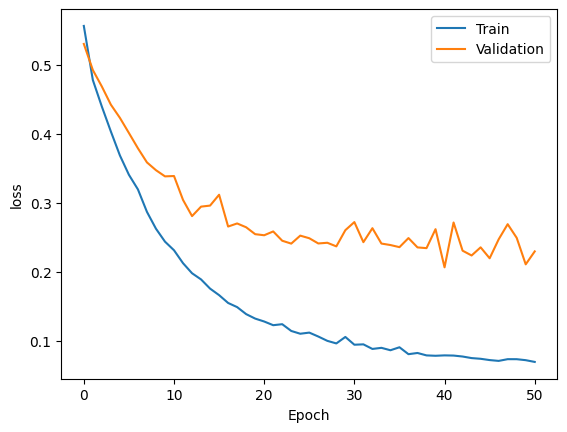

In [106]:
plt.plot(history20.history['loss'])
plt.plot(history20.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [107]:
y_predtrain_pop20 = model20.predict(X_train)
y_predtrain_pop20 = (y_predtrain_pop20 > 0.5)

from sklearn.metrics import confusion_matrix
cm_train_pop20 = confusion_matrix(y_train, y_predtrain_pop20)

237/237 [==============================] - 0s 2ms/step


In [108]:
cm_train_pop20

array([[3659,  146],
       [  29, 3734]])

In [109]:
print("F1-score :", f1_score(y_train, y_predtrain_pop20))
print("Accuracy :", accuracy_score(y_train, y_predtrain_pop20))
print("Precision :", precision_score(y_train, y_predtrain_pop20))
print("Recall :", recall_score(y_train, y_predtrain_pop20))

F1-score : 0.977103231715295
Accuracy : 0.9768763213530656
Precision : 0.9623711340206186
Recall : 0.9922933829391443


In [110]:
y_predtest_pop20 = model20.predict(X_test)
y_predtest_pop20 = (y_predtest_pop20 > 0.5)

from sklearn.metrics import confusion_matrix
cm_test_pop20 = confusion_matrix(y_test, y_predtest_pop20)

73/73 [==============================] - 0s 2ms/step


In [111]:
cm_test_pop20

array([[1862,  166],
       [  95,  186]])

In [112]:
print("F1-score :", f1_score(y_test, y_predtest_pop20))
print("Accuracy :", accuracy_score(y_test, y_predtest_pop20))
print("Precision :", precision_score(y_test, y_predtest_pop20))
print("Recall :", recall_score(y_test, y_predtest_pop20))

F1-score : 0.5876777251184834
Accuracy : 0.8869640537029017
Precision : 0.5284090909090909
Recall : 0.6619217081850534


#CONVERGENCE PLOT

In [121]:
conv5 = joblib.load("{}/covgdata_pop5.pkl".format(savepath))
conv10 = joblib.load("{}/covgdata_pop10.pkl".format(savepath))
conv15 = joblib.load("{}/covgdata_pop15.pkl".format(savepath))
conv20 = joblib.load("{}/covgdata_pop20.pkl".format(savepath))

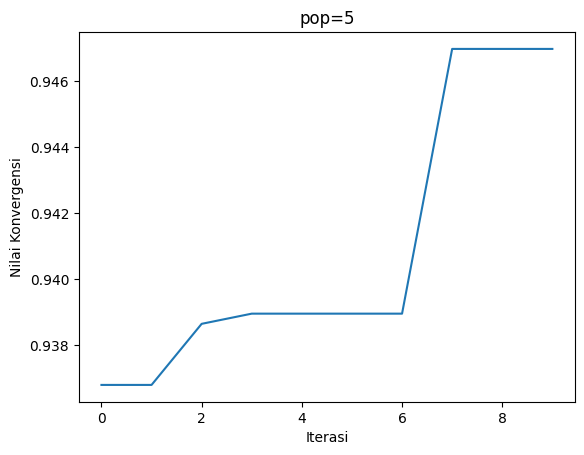

In [122]:
x_5, y_5 = conv5[5]
plt.plot(x_5, y_5)
plt.title('pop=5')
plt.xlabel('Iterasi')
plt.ylabel('Nilai Konvergensi')
plt.show()

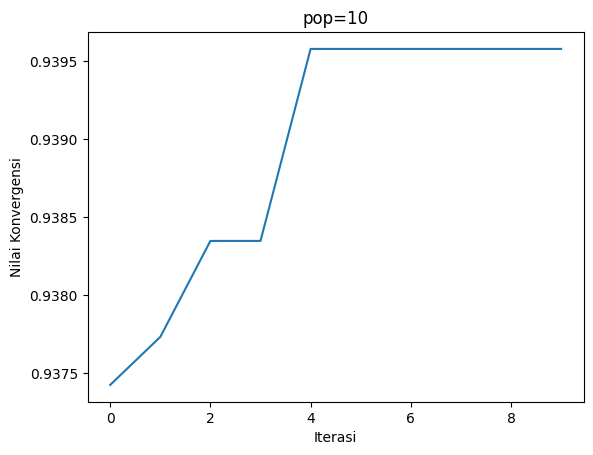

In [123]:
x_10, y_10 = conv10[10]
plt.plot(x_10, y_10)
plt.title('pop=10')
plt.xlabel('Iterasi')
plt.ylabel('Nilai Konvergensi')
plt.show()

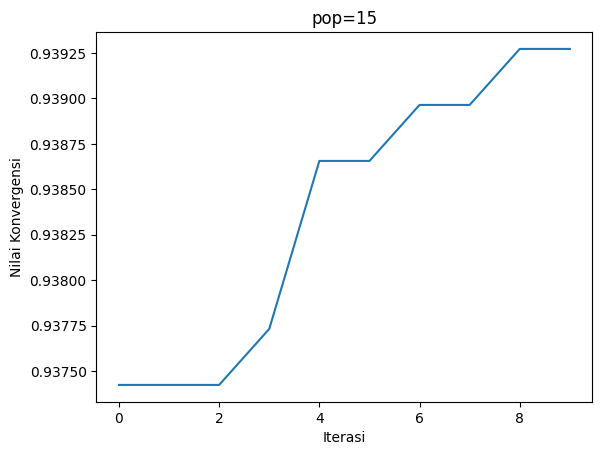

In [124]:
x_15, y_15 = conv15[15]
plt.plot(x_15, y_15)
plt.title('pop=15')
plt.xlabel('Iterasi')
plt.ylabel('Nilai Konvergensi')
plt.show()

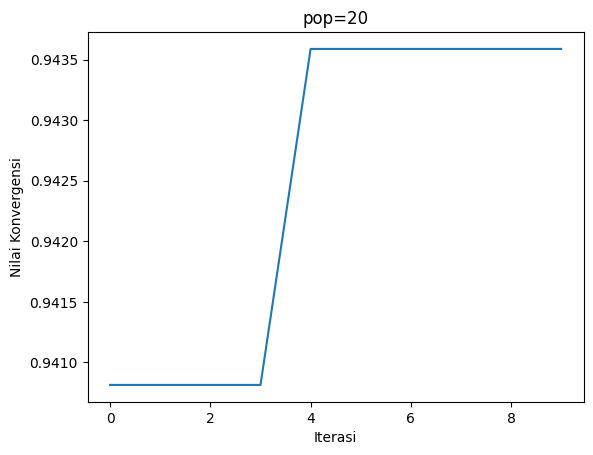

In [125]:
x_20, y_20 = conv20[20]
plt.plot(x_20, y_20)
plt.title('pop=20')
plt.xlabel('Iterasi')
plt.ylabel('Nilai Konvergensi')
plt.show()

#PLOT GABUNGAN


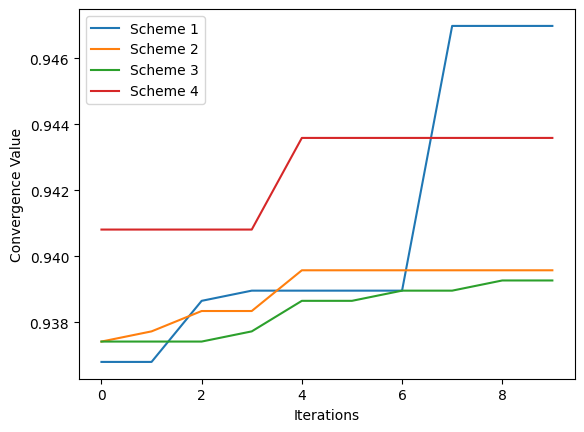

In [129]:
# Serangkaian nilai konvergensi
values1 = y_5
values2 = y_10
values3 = y_15
values4 = y_20



# Membuat plot
plt.plot(x_5, values1, label='Scheme 1')
plt.plot(x_10, values2, label='Scheme 2')
plt.plot(x_15, values3, label='Scheme 3')
plt.plot(x_20, values4, label='Scheme 4')



# Memberikan judul pada sumbu x dan y
plt.xlabel('Iterations')
plt.ylabel('Convergence Value')

# Menambahkan legenda
plt.legend()

# Menampilkan plot
plt.show()

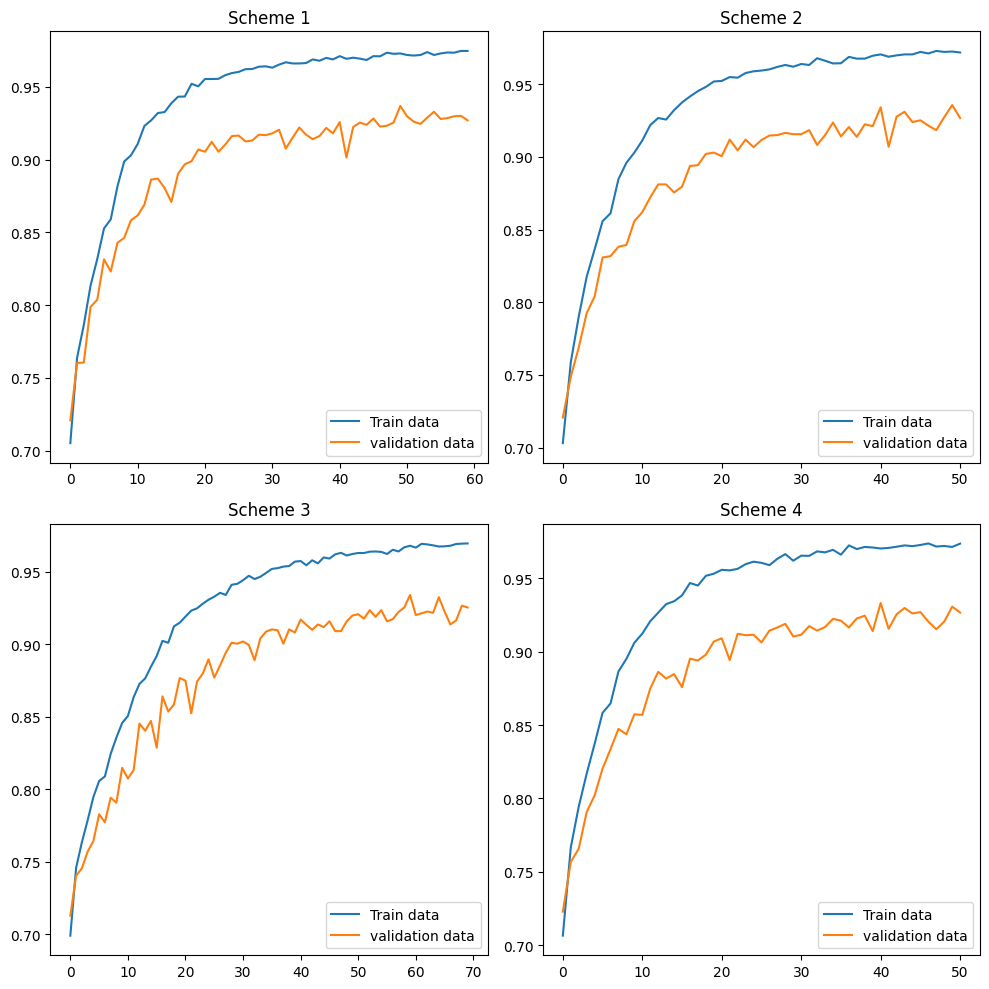

In [130]:
# Membuat grid 3x3
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1
axs[0, 0].set_title("Scheme 1")
axs[0, 0].plot(history5.history['accuracy'], label = "Train data")
axs[0, 0].plot(history5.history['val_accuracy'], label = "validation data")
axs[0, 0].legend(loc = "lower right")

# Plot 2
axs[0, 1].set_title("Scheme 2")
axs[0, 1].plot(history10.history['accuracy'], label = "Train data")
axs[0, 1].plot(history10.history['val_accuracy'], label = "validation data")
axs[0, 1].legend(loc = "lower right")

# Plot 3
axs[1, 0].set_title("Scheme 3")
axs[1, 0].plot(history15.history['accuracy'], label = "Train data")
axs[1, 0].plot(history15.history['val_accuracy'], label = "validation data")
axs[1, 0].legend(loc = "lower right")

# Plot 4
axs[1, 1].set_title("Scheme 4")
axs[1, 1].plot(history20.history['accuracy'], label = "Train data")
axs[1, 1].plot(history20.history['val_accuracy'], label = "validation data")
axs[1, 1].legend(loc = "lower right")

# Menampilkan plot
plt.tight_layout()
plt.show()

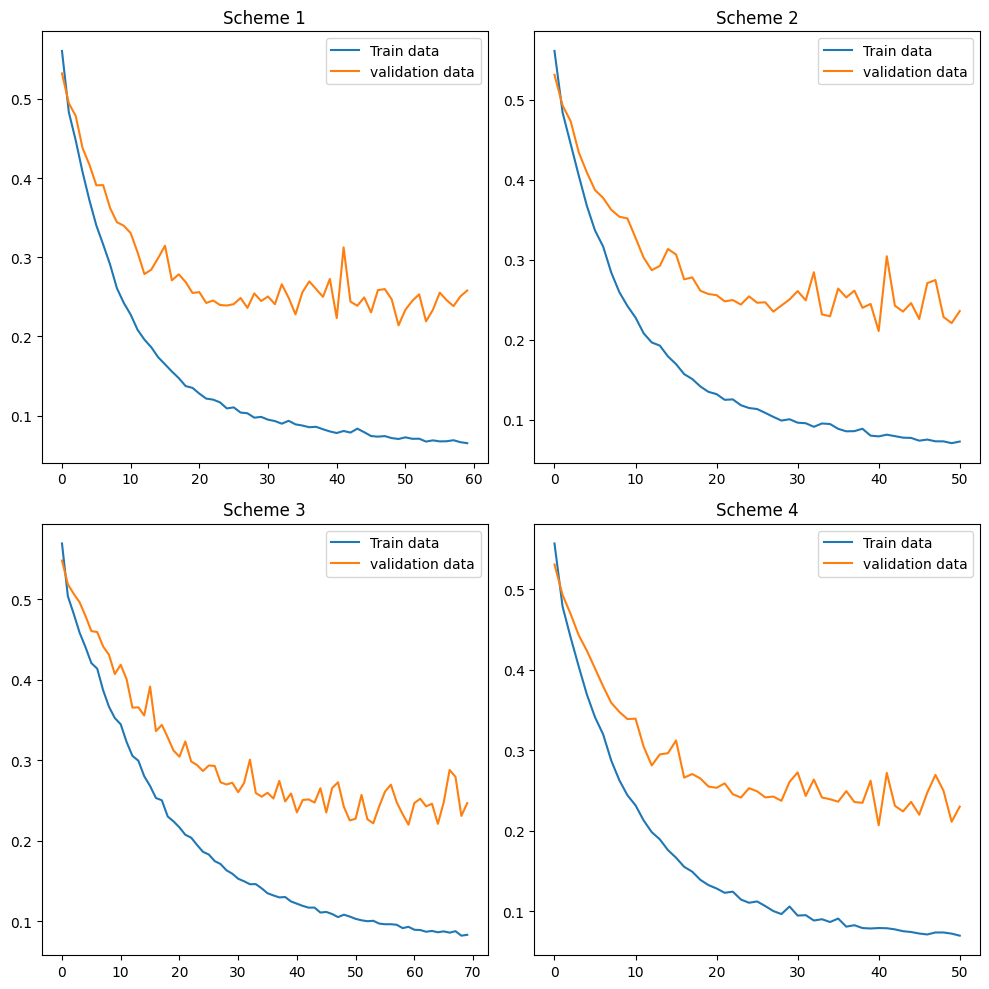

In [131]:
# Membuat grid 3x3
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1
axs[0, 0].set_title("Scheme 1")
axs[0, 0].plot(history5.history['loss'], label = "Train data")
axs[0, 0].plot(history5.history['val_loss'], label = "validation data")
axs[0, 0].legend(loc = "upper right")

# Plot 2
axs[0, 1].set_title("Scheme 2")
axs[0, 1].plot(history10.history['loss'], label = "Train data")
axs[0, 1].plot(history10.history['val_loss'], label = "validation data")
axs[0, 1].legend(loc = "upper right")

# Plot 3
axs[1, 0].set_title("Scheme 3")
axs[1, 0].plot(history15.history['loss'], label = "Train data")
axs[1, 0].plot(history15.history['val_loss'], label = "validation data")
axs[1, 0].legend(loc = "upper right")

# Plot 4
axs[1, 1].set_title("Scheme 4")
axs[1, 1].plot(history20.history['loss'], label = "Train data")
axs[1, 1].plot(history20.history['val_loss'], label = "validation data")
axs[1, 1].legend(loc = "upper right")

# Menampilkan plot
plt.tight_layout()
plt.show()